In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy
import random
import pandas as pds
from scipy.optimize import minimize


In [2]:
def poissant_distribution(n, lambda_val):
    return np.exp(-lambda_val) * (lambda_val**n) / np.math.factorial(n)

def negative_probability_distribution(lambda_val, n):
    return -poissant_distribution(n, lambda_val)

def maximize_distribution(n):
    result = scipy.optimize.minimize(negative_probability_distribution, x0=[5], bounds=[(0,None)], args=(n,))
    return result.x

def rand_bins():
    numbers = set()
    while len(numbers) < 3:
        numbers.add(random.randint(0, 71))
    return numbers

bin1, bin2, bin3 = rand_bins()

bin1=18

print(maximize_distribution(0))

[0.]


In [3]:
#importing and sorting data
ge_data = pds.read_csv("SuperCDMS/PhysRevD.99.062001-data/MarchAprilFinal.txt", skiprows=1, \
                         names=['time', 'blah'], \
                         delim_whitespace=False
                     )

ge_data = ge_data.sort_values(by='time')

t = np.asarray(ge_data["time"], dtype=np.float32)

In [4]:
min_t=np.min(t)

#construct histogram from our data, every bin is roughly 12 hours
counts, bins = np.histogram(t-min_t,bins=72)
thing = (bins[:-1]+bins[1:])/2
error1 = [0.00,0.37,0.74,1.10,2.34,2.75,3.82,4.25,5.30,6.33,6.78,7.81,8.83,9.28]
error2 = [1.29,2.75,4.25,5.30,6.78,7.81,9.28,10.30,11.32,12.79,13.81,14.82,16.29,17.30]
ntot_plus = np.zeros(np.shape(counts))
ntot_minus = np.zeros(np.shape(counts))
for i,ncount in enumerate(counts):
    if ncount<=20:
        ntot_plus[i] = error2[ncount]-ncount
        ntot_minus[i] = ncount-error1[ncount]
    else:
        ntot_plus[i] = np.sqrt(ncount)
        ntot_minus[i] = np.sqrt(ncount)

In [5]:
lambda_array = []
for i in range(len(counts)):
    result=maximize_distribution(counts[i])
    lambda_array.extend(result)

prob_array = []
for i in range(len(lambda_array)):
    result=poissant_distribution(counts[i], lambda_array[i])
    prob_array.extend([result])

counts_array=np.asarray(counts)
print(counts_array)

[13  9  5  6  5  7  6  1  2  4  4  5  5  5  6  2  3  3  0  3  3  5  5  4
  3  4  2  3  1  3  4  0  3  1  3  4  2  3  1  2  2  1  2  2  1  2  1  1
  3  2  1  0  0  1  1  1  1  1  1  2  1  2  0  1  0  2  1  1  1  1  1  2]


In [6]:

def log_likelihood_func(theta, n1, n2, n3): 
    lambda1, lambda2, lambda3 = theta
    sterling1 = 1
    sterling2 = 1
    sterling3 = 1 #sterling approximation for large values of n so the factorial function does not run into problems
    if n1 > 12: 
        sterling1 = n1*np.log(n1)-n1
    else:
        sterling1 = np.log(np.math.factorial(n1))
        
    if n2 > 12: 
        sterling2 = n2*np.log(n2)-n2
    else:
        sterling2 = np.log(np.math.factorial(n2))
    
    if n3 > 12: 
        sterling3 = n3*np.log(n3)-n3
    else:
        sterling3 = np.log(np.math.factorial(n3))

    model = (-lambda1 + n1*np.log(lambda1)-sterling1)+(-lambda2 + n2*np.log(lambda2)-sterling2)+(-lambda3 + n3*np.log(lambda3)-sterling3)
    return model

#def log_likelihood_func(theta, n): 
 #   lambda_val = theta
  #  sterling = 1 #sterling approximation for large values of n so the factorial function does not run into problems
  #  if n > 20: 
  #      sterling = n*np.log(n)-n
  #  else:
  #      sterling = np.log(np.math.factorial(n))

#    model = -lambda_val + n*np.log(lambda_val)-sterling #natural log of L(lambda, n) = e^-lambda * lambda^n / n!
 #   return model

n1=counts_array[bin1]
n2=counts_array[bin2]
n3=counts_array[bin3]
l1=lambda_array[bin1]
l2=lambda_array[bin2]
l3=lambda_array[bin3]

nll = lambda *args: -log_likelihood_func(*args)
initial = np.array([l1, l2, l3]) #initial parameter vals? 
soln = scipy.optimize.minimize(nll, initial, args=(n1, n2, n3), bounds=[(0,20),(0,20),(0,20)]) #add bounds?
lambda1_ml, lambda2_ml, lambda3_ml = soln.x
print(soln.x)

#nll = lambda *args: -log_likelihood_func(*args)
#initial = np.asarray([l1]) #initial parameter vals? 
#soln = scipy.optimize.minimize(nll, initial, args=(c1)) 
#lambda1_ml = soln.x


[0.         5.         1.00000327]


C:\Users\cecih\AppData\Local\Temp\ipykernel_29496\1070097413.py:21: RuntimeWarning: divide by zero encountered in log
  model = (-lambda1 + n1*np.log(lambda1)-sterling1)+(-lambda2 + n2*np.log(lambda2)-sterling2)+(-lambda3 + n3*np.log(lambda3)-sterling3)
C:\Users\cecih\AppData\Local\Temp\ipykernel_29496\1070097413.py:21: RuntimeWarning: invalid value encountered in multiply
  model = (-lambda1 + n1*np.log(lambda1)-sterling1)+(-lambda2 + n2*np.log(lambda2)-sterling2)+(-lambda3 + n3*np.log(lambda3)-sterling3)


In [7]:
print(bin1,bin2,bin3)
print(counts_array[bin1], counts_array[bin2], counts_array[bin3])
def prior(theta): #this sets the prior conditions of our parameters
    lambda1, lambda2, lambda3 = theta
    if lambda1>=0 and lambda2>=0 and lambda3>=0:
        return 0.0
    return -np.inf

def prob(theta, n1, n2, n3):
    lp = prior(theta)
    if not np.isfinite(lp):
        return -np.inf 
    result = lp + log_likelihood_func(theta, n1, n2, n3)
    if np.isnan(np.asarray([result])):
        return -np.inf
    return result

18 11 68
0 5 1


In [8]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, prob, args=(n1, n2, n3)
)

sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\cecih\.conda\envs\neutroncapture\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:23<00:00, 209.88it/s]


[57.48601857 41.64956403 46.8619939 ]
(10432, 3)


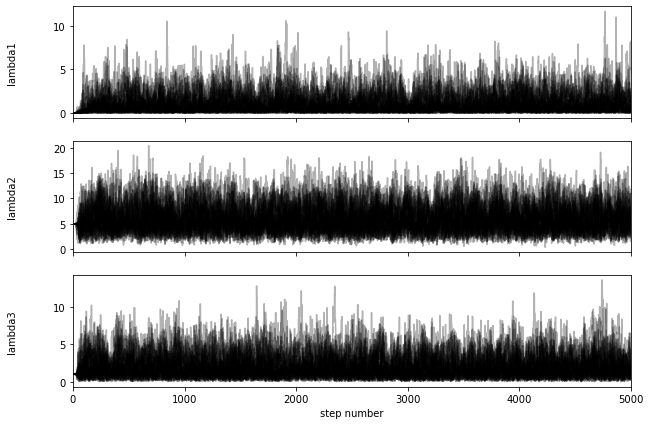

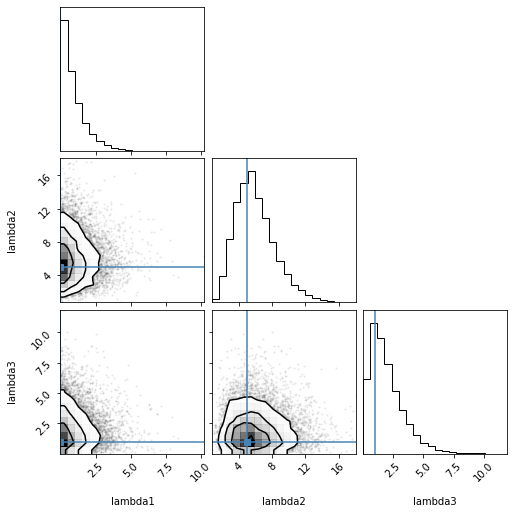

In [9]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["lambda1","lambda2","lambda3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#autocorrelation stuffs
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels, truths=[lambda1_ml, lambda2_ml, lambda3_ml]
);